In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=11oDZ6JvJS0xP_u_YE55IFoX1C8TzDKQB

Downloading...
From: https://drive.google.com/uc?id=11oDZ6JvJS0xP_u_YE55IFoX1C8TzDKQB
To: /content/train.csv
100% 461k/461k [00:00<00:00, 3.10MB/s]


In [ ]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

В учебных целях в первой задаче запрещено использовать готовые реализации линейной регрессии (например, из пакета *scikit-learn*).

## Задача 1 (10 баллов)

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние. 

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$ 
 
где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i$ независимы и распределены по закону $N(0, \sigma^2)$. 

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени. 

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1gmSof1yxWt009QoBiKjwkLMlcpn3r61W

Downloading...
From: https://drive.google.com/uc?id=1gmSof1yxWt009QoBiKjwkLMlcpn3r61W
To: /content/regression.csv
100% 9.98k/9.98k [00:00<00:00, 22.3MB/s]


In [ ]:
X = np.genfromtxt('regression.csv')
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])

Размер датасета: (1000,)
Средняя скорость: 12.0408175


Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

Построим график показаний датчика:

In [ ]:
N=1000

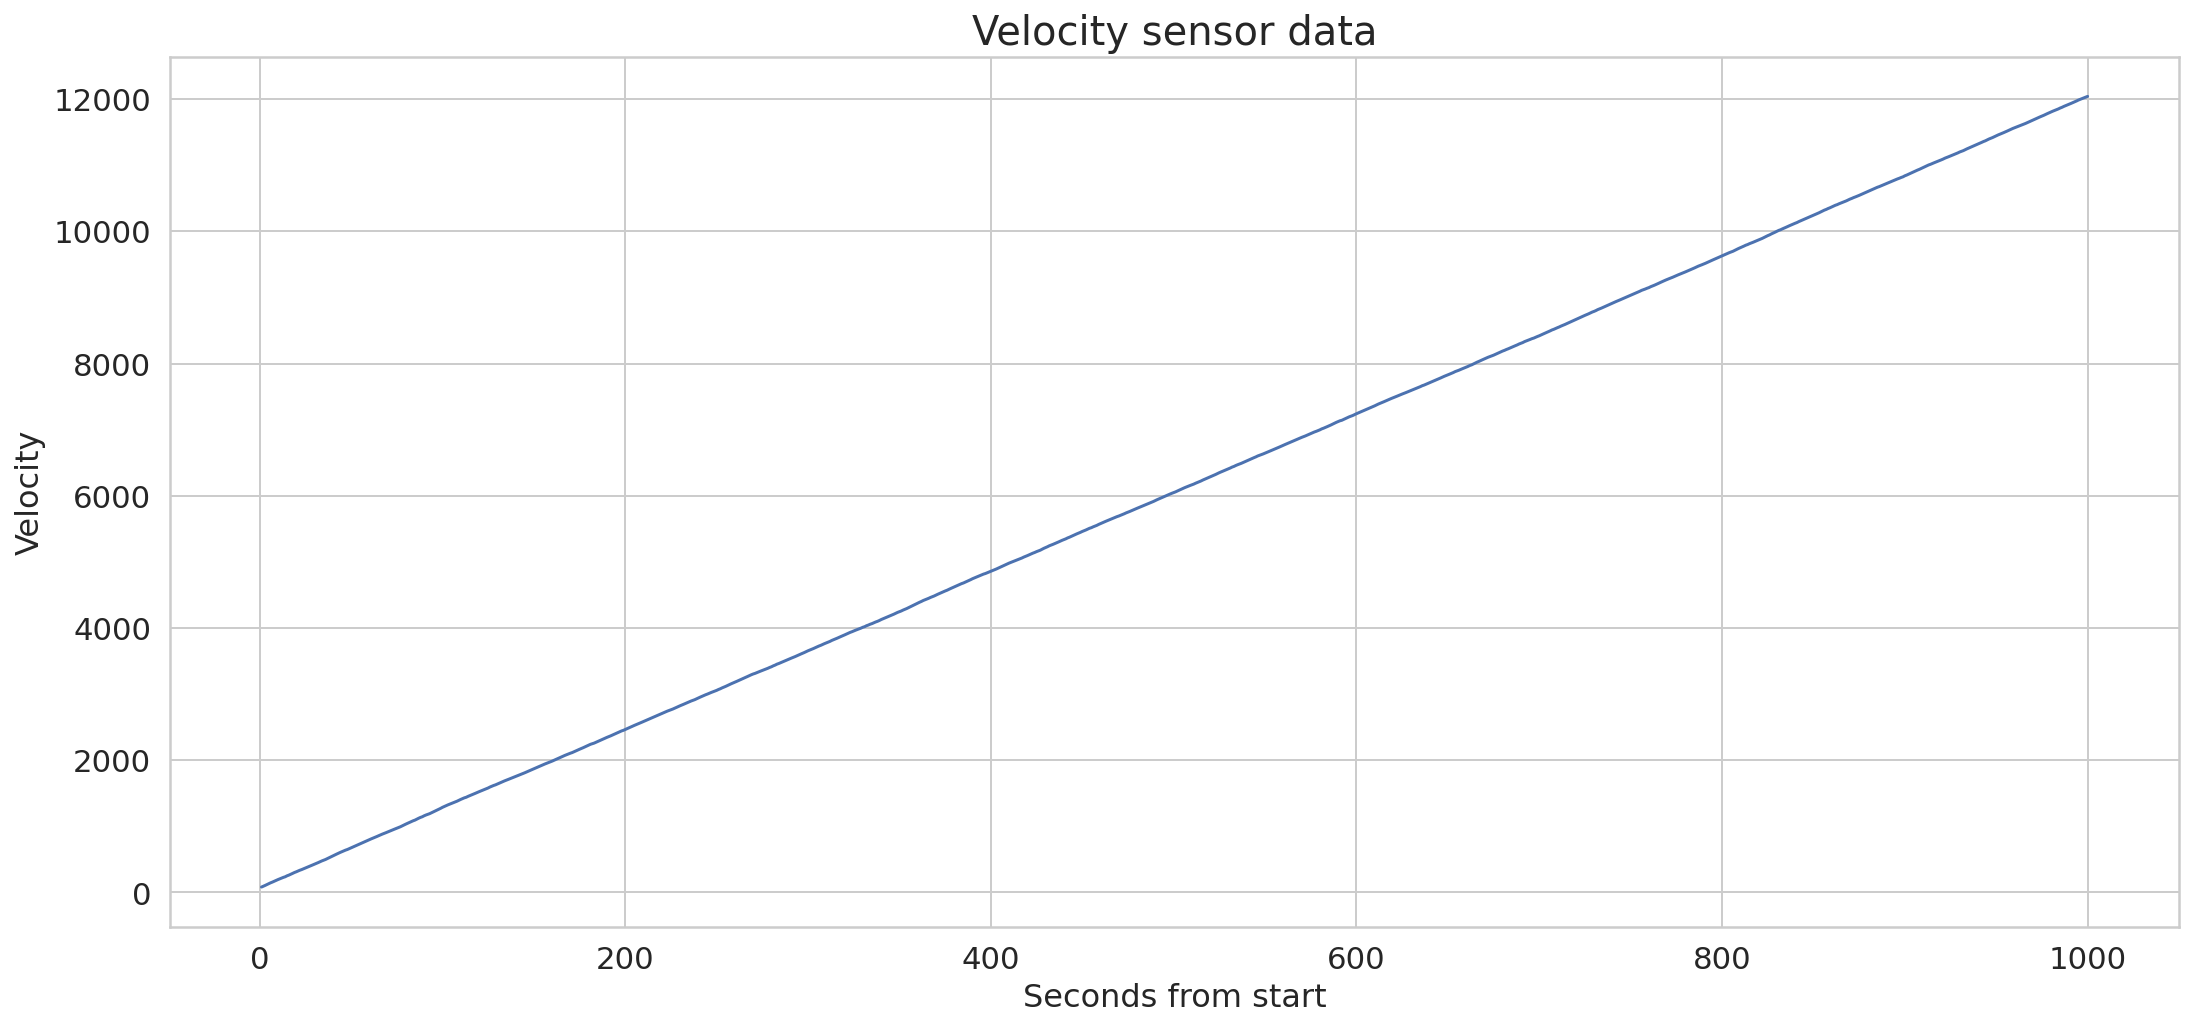

In [ ]:
fig, axis = plt.subplots(figsize=(18,8))
plt.title('Velocity sensor data', fontsize=20)
grid = np.arange(N) + 1
axis.plot(grid, X, label='Velocity sensor data')
axis.set_xlabel('Seconds from start', fontsize=16)
axis.set_ylabel('Velocity', fontsize=16)
plt.show()

Видим, что график линейный. Для оценки параметров $\beta_1$ и $\beta_2$ воспользуемся гауссовской линейной моделью. 

#### 1. Сведем задачу к гауссовской линейной модели

Каким образом свести изначальную задачу к гауссовской линейной модели? Останется ли распредление вектора ошибок тем же? Новый вектор наблюдений назовите $Y$.

Расстояние, которе проехал трамвай за $i$ секунд по показанию датчика: 
$$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n,$$
где $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика.

Эта задача изначально не удовлетворяет требованиям линейной модели, потому что вектор наблюдейний $X$ задан в другом виде, но ее можно свести к линейной регрессии таким образом:
$$ Y = 
\left(\begin{array}{cc} 
X_0 \\
X_1 - X_0 \\
X_2 - X_1 \\
\dots \\
X_n - X_{n-1} \\
\end{array}\right) = 
\left(\begin{array}{cc} 
\beta_1 + \varepsilon_0 \\
\beta_2 + \varepsilon_1 \\
\beta_2 + \varepsilon_2 \\
\dots \\
\beta_2 + \varepsilon_n \\
\end{array}\right),
$$
где вектор $Y$ --- это новый столбец наблюдецний.

Столбец $Y$ представляется в виде $Y = l + \varepsilon$, где $l$ --- это измеряемая величина (состоит из $\beta_1$ и $\beta_2$), а $\varepsilon$ --- ошибка измерения.

Заметим, что при преобразовании $X$ в $Y$ вектор ошибок остался из того же распределения. Изначально ошибки измерений были одинаково распределены: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, после вычетания, по свойствами нормального распределения получим случайную величину из того же распределения: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$.

In [ ]:
shift = np.append(np.zeros(1), X[:-1])
Y = X - shift

#### 2. Требования к гауссовской линейной модели

Напомним, что в гауссовской линейной модели наблюдение -- вектор $X \in \mathbb{R}^n$, представимо в виде $X = l + \varepsilon$, где $l$ --- неизвестный случайный вектор (измеряемая величина), $\varepsilon$ --- случайный вектор (ошибка измерения), имеющий распредление $\mathcal{N}(\vec{0}, \sigma^2 I)$. То есть среднее значение ошибки измерения должно быть равно нулю и в нашей модели для всех измерений ошибки должны иметь одинаковую дисперсию (гомоскедастичность).

Проверим, что дисперсия ошибки не меняется со временем

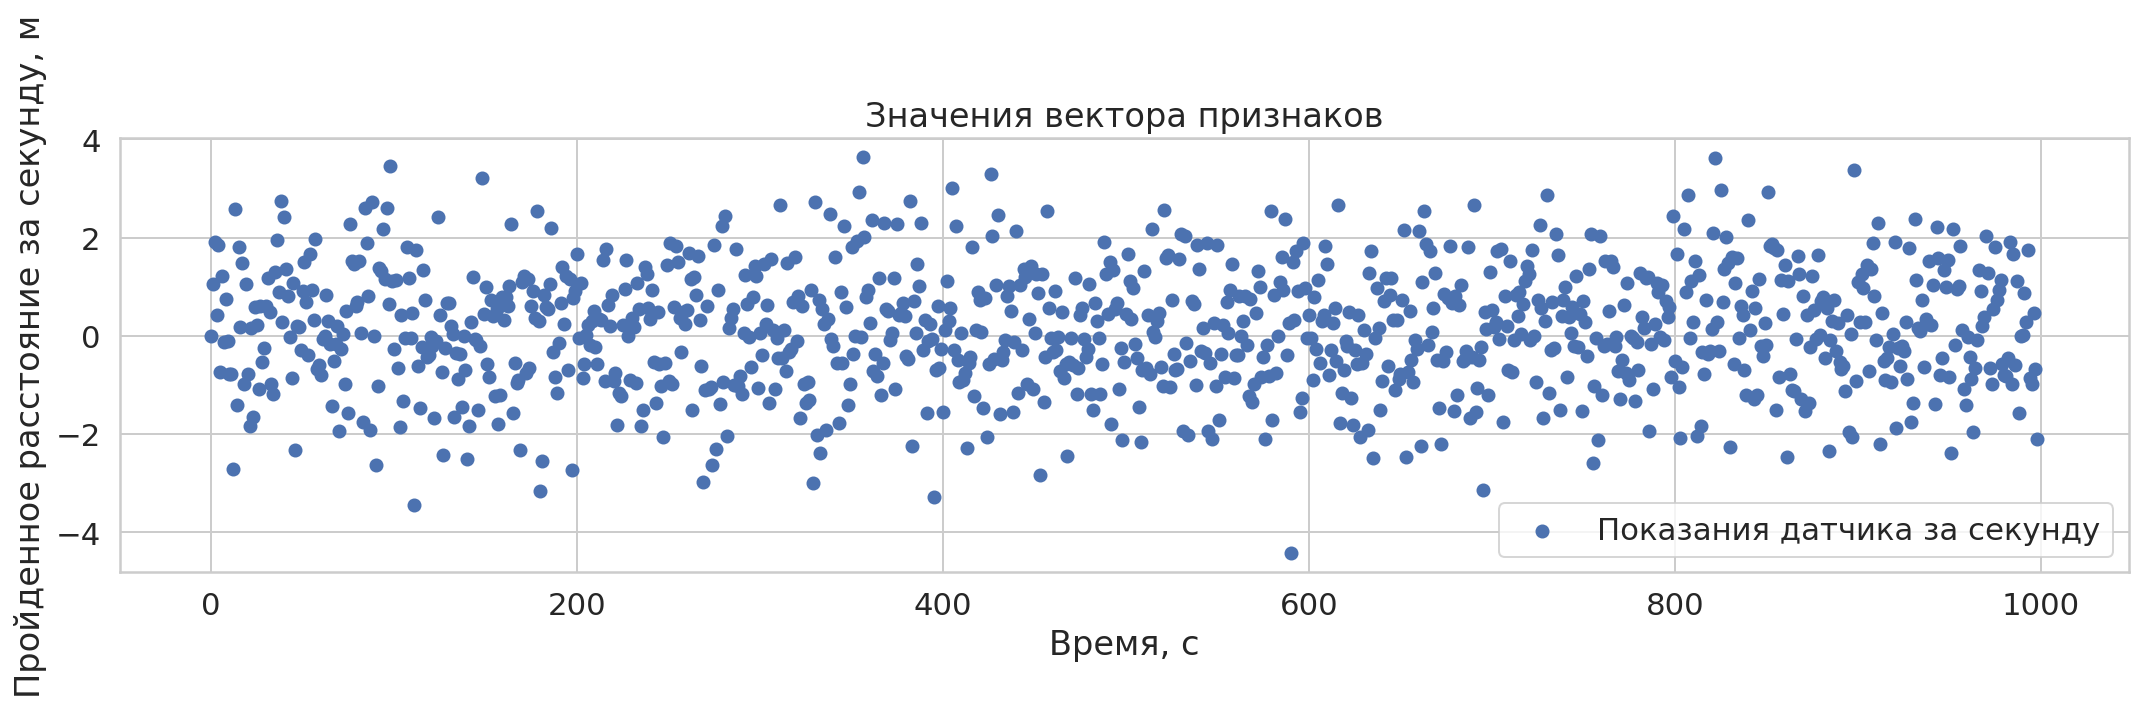

In [ ]:
time = np.arange(Y.shape[0] - 1)
plt.figure(figsize=(18,4))
plt.title("Значения вектора признаков")
plt.scatter(time, Y[1:] - Y[1], label="Показания датчика за секунду")
plt.xlabel("Время, с")
plt.ylabel("Пройденное расстояние за секунду, м")
plt.legend()

plt.show()

Проверим, что ошибка имеет нормальное распределение. Для этого сравним распредление ошибок и теоретическое нормальное распредление с помощбю графика QQ-plot:

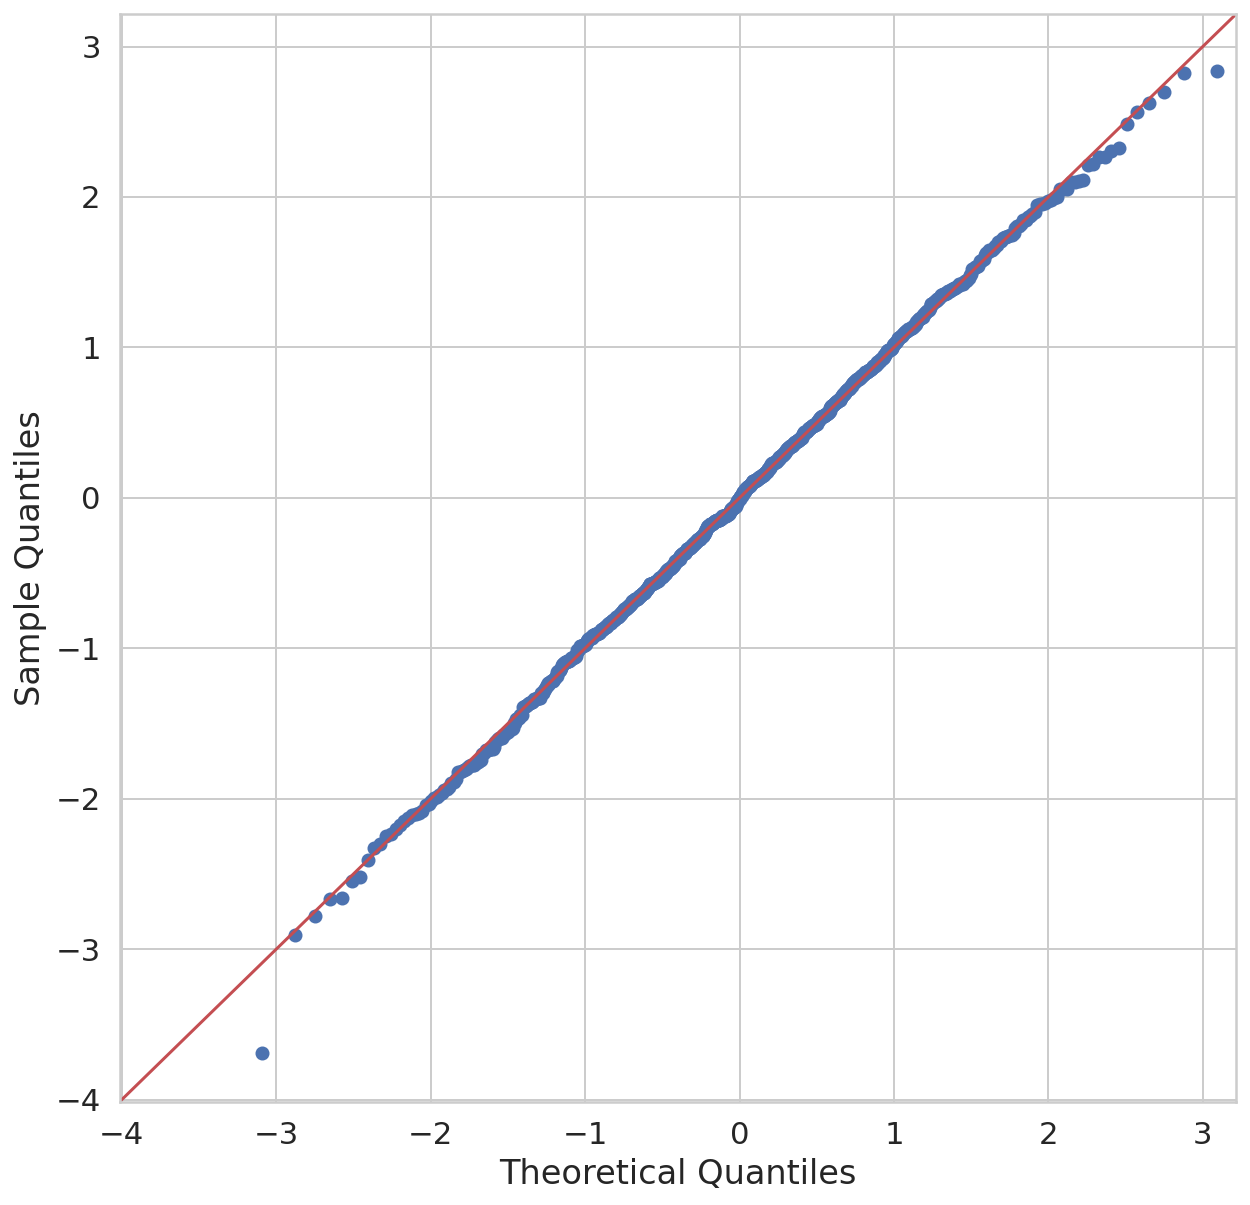

In [ ]:
import statsmodels.api as sm


fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(Y[1:] - Y[1], line='45', ax=ax, fit=True) 
fig.show()

__Вывод__
Как мы видим теоретические квантили нормального распределения (с какими-то параметрами) почти идеально совпадают с квантилями нашего распределения. Что говорит о том, что они, скорее всего, совпадают.

#### 3. Оценка параметров

Воспользуйтесь реализованным в начале задания классом `LinearModel`. Как выглядит ваша матрица признаков $Z$? Какие значения параметров $\beta_1$ и $\beta_2$?

Вектор $l$ представляется в виде: $l = Z\theta$, где $\theta$ --- это вектор искомых весов: 
$\theta = 
\left(\begin{array}{cc} 
\beta_1 \\
\beta_2 \\
\end{array}\right)$, матрица признаков $Z = 
\left(\begin{array}{cc} 
1 & 0 \\
0 & 1 \\
\dots & \dots\\
0 & 1 \\
\end{array}\right)$ имеет высоту $n$.

Линейную модель можно представить так: $Y = Z\theta + \varepsilon$.

Оценка $\theta$ методом наименьших квадратов: $$\hat{\theta} = \arg \min_\theta || Y - Z\theta ||^2.$$ Для этой задачи существует аналитическое решение: 

$$\hat{\theta} = (Z^TZ)^{-1}Z^TY.$$

In [ ]:
Z = np.array([1, 0] + [0, 1] * (Y.shape[0] - 1))
Z = Z.reshape((Y.shape[0], 2))

In [ ]:
class LinearModel:
  def __init__(self):
    self.params = None
    self.trained = False
  
  def fit(self, Z: np.ndarray, Y: np.ndarray):
    self.params = np.linalg.inv(Z.T @ Z) @ Z.T @ Y
    self.trained = True
    return self
  def predict(self, X: np.ndarray):
    assert self.trained, 'Model is not trained to call predict'
    return X @ self.params

  def get_params(self):
    assert self.trained, 'Model is not trained to call predict'
    return self.params

  def evaluate_square_error(self, Z: np.ndarray, Y: np.ndarray):
    return np.sum((Y - Z @ self.params)**2)

In [ ]:
linear_model = LinearModel().fit(Z, Y)
linear_model.get_params()

array([82.0053    , 11.97078298])

Итого, получаем,  значения $\beta_1$ и $\beta_2$ -- начальное расстояние и скорость: $\beta_1 = 82.0053\ (м), \beta_2 = 11.9707\ (м/с)$.

#### 4. Оценка дисперсии ошибки показаний датчика.

Найдите оценку дисперсии $\sigma^2$ показаний датчика $\varepsilon$. После того, как она найдена, найдите оценку дисперсии $\sigma^2$ ошибки отсчёта времени $\varepsilon^t$.

Существует несмещенная оценка $\sigma^2$:
$$\dfrac{1}{n-k}||Y - Z\hat{\theta}||_2^2,$$ где $n$ --- число измерений, $k$ --- размер вектора весов. В нашем случае $n = 1000$ (размер выборки), $k = 2$ (число весов: $\beta_1$ и $\beta_2$).

In [ ]:
K=2

In [ ]:
sigma_hat = 1/(N - K) * linear_model.evaluate_square_error(Z, Y)
print("Несмещённая оценка дисперсии линейной модели:", sigma_hat)

Несмещённая оценка дисперсии линейной модели: 1.5252448716139118


Найдём оценку дисперсии ошибки отсчёта времени $\varepsilon_i^t.$ До этого нашли $\varepsilon$ --- ошибка приращения расстояния. Ошибка отсчета времени связана с ошибкой приращения расстояния так: $\varepsilon = \varepsilon^t \beta_2,$ где $\varepsilon^t$ --- ошибка отсчета времени.

Раз $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, то $\varepsilon^t = \varepsilon/\beta_2 \sim \mathcal{N}\left(0, \dfrac{\sigma^2}{\beta_2 ^ 2}\right)$

In [ ]:
print("Оценка дисперсии ошибки отсчёта времени", sigma_hat / linear_model.get_params()[1]**2)

Оценка дисперсии ошибки отсчёта времени 0.010643744924922064


#### 5. Измерим качество модели

В качестве метрики качества модели, эксперты предложили использовать [коэффициент детерминанции](https://ru.wikipedia.org/wiki/Коэффициент_детерминации). Он показывает какую долю дисперсии выборки объясняет линейная регрессия. В нашем случае, значение $R^2 > 0.98$ будет означать, что трамвай прошел испытание.

In [ ]:
time = np.arange(X.shape[0]) + 1
res = np.array([linear_model.get_params()[0] + linear_model.get_params()[1] * time - X]) 
ss_res = np.sum(res**2)
ss_tot = np.sum((X - X.mean())**2)
print("R^2 = ", 1 - ss_res / ss_tot)

R^2 =  0.9999680124927224


Ответ в задаче:

$\beta_1 = 82.0053$ -- начальное расстояние,

$\beta_2 = 11.9708$ -- скорость движения,

$\sigma^2 = 1.5252$ -- дисперсия отсчета расстояния,

$\sigma_t^2 = 0.0106$ -- дисперсия отсчета времени.

### Вывод 
Трамвай прошел испытание, так как $R^2 > 0.98$

## Задача 2 (20 баллов)

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png).

В частности мы будем смотреть на влияние различных признаков на стоимость дома и проверим несколько гипотез.

In [ ]:
from scipy import stats as sps

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [ ]:
df = pd.read_csv("train.csv")
df.fillna("NA", inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка. Давайте заменим строки на числа, сохранив при этом порядок.

In [ ]:
useful_columns = [
    "OverallQual", 
    "GrLivArea", 
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

filtered_df = df.loc[:, useful_columns]

transforms = {
    "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "ExterQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
}

for column_name, transform in transforms.items():
    filtered_df.loc[:, column_name] = filtered_df.loc[:, column_name].apply(lambda x: transform[x])


In [ ]:
filtered_df.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,PoolArea,BsmtQual,TotalBsmtSF,GarageFinish,SalePrice
0,7,1710,4,4,548,0,4,856,2,208500
1,6,1262,3,3,460,0,4,1262,2,181500
2,7,1786,4,4,608,0,4,920,2,223500
3,7,1717,3,4,642,0,3,756,1,140000
4,8,2198,4,4,836,0,4,1145,2,250000


### Изучение данных

Перед тем, как начать использовать линейные модели необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать корреляцию Пирсона. Используя ``sns.heatmap`` постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика алекватным, например, ``figsize=(11, 10)``.

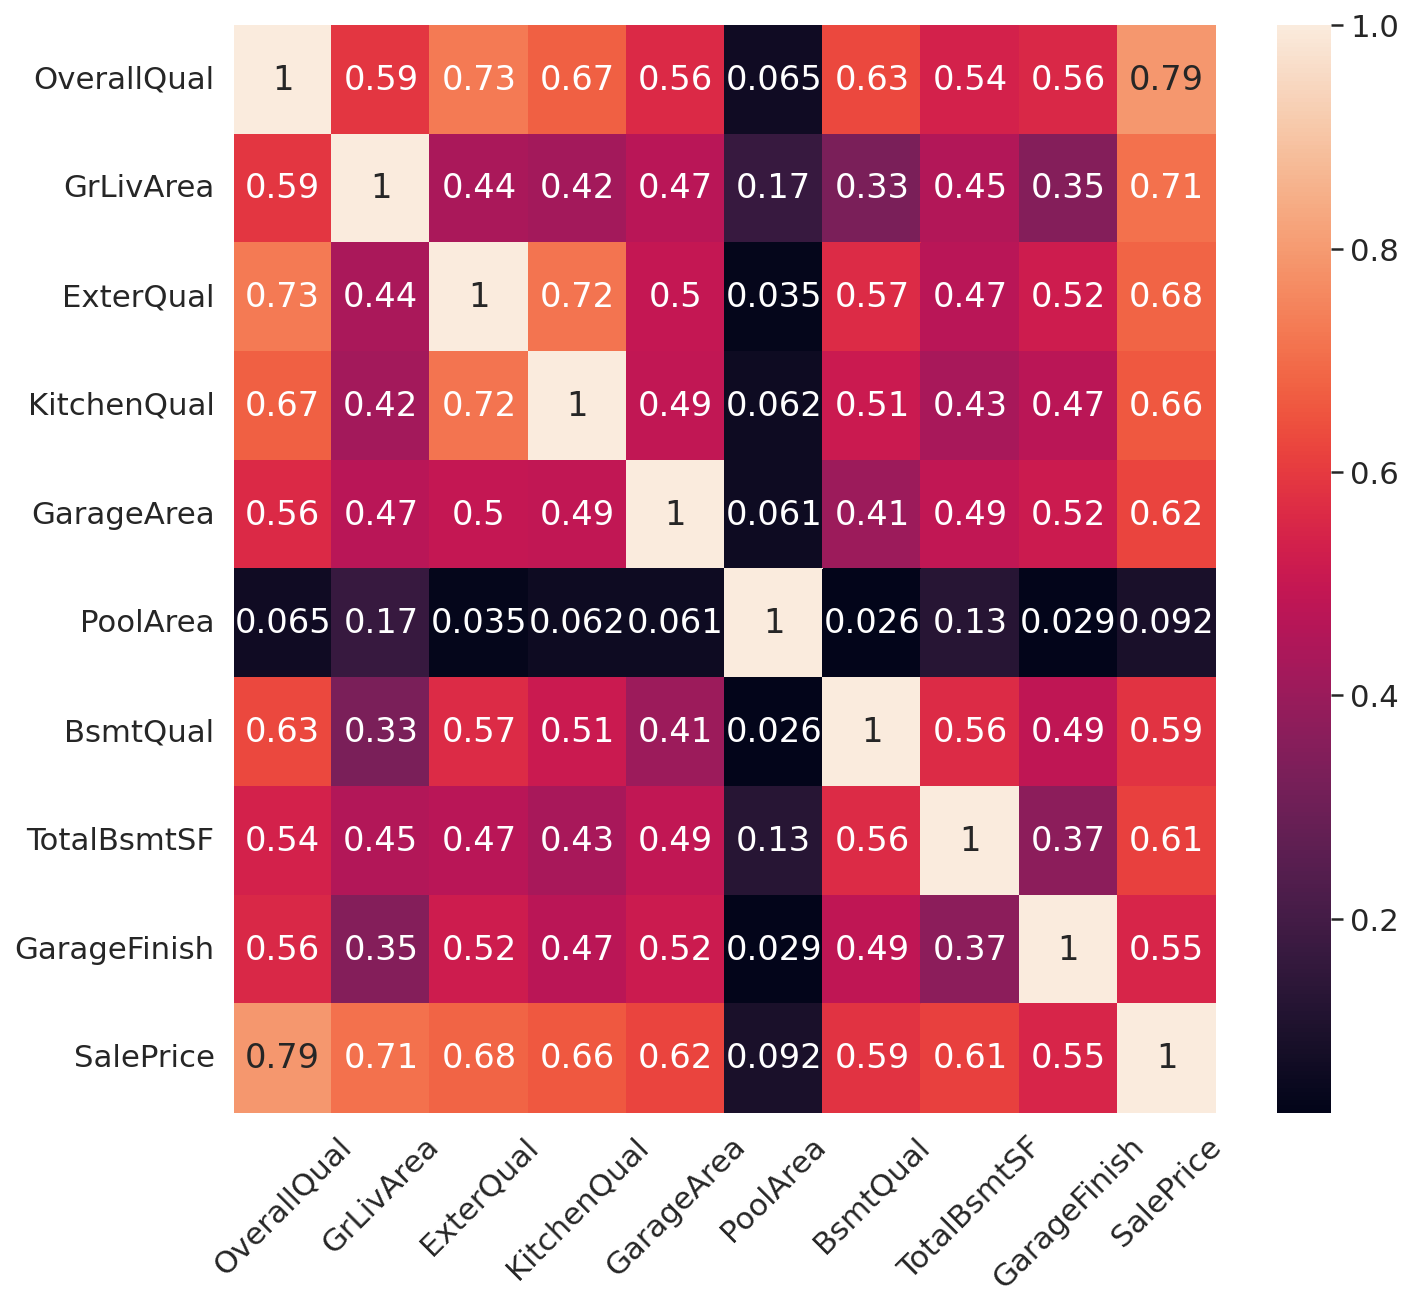

In [ ]:
plt.figure(figsize=(11, 10))
sns.heatmap(filtered_df.corr(), annot=True) #.drop(columns=['SalePrice'])
plt.xticks(rotation=45) 
plt.show()

Посмотрите на график выше: есть ли на нем линейно зависимые признаки ($|r_{XY}| > 0.9$)? 

**Ответ:** таких признаков нет.

Удалите, если требуется, один из двух скоррелированных признаков в ячейке ниже.

In [ ]:
filtered_df = filtered_df

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонале $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

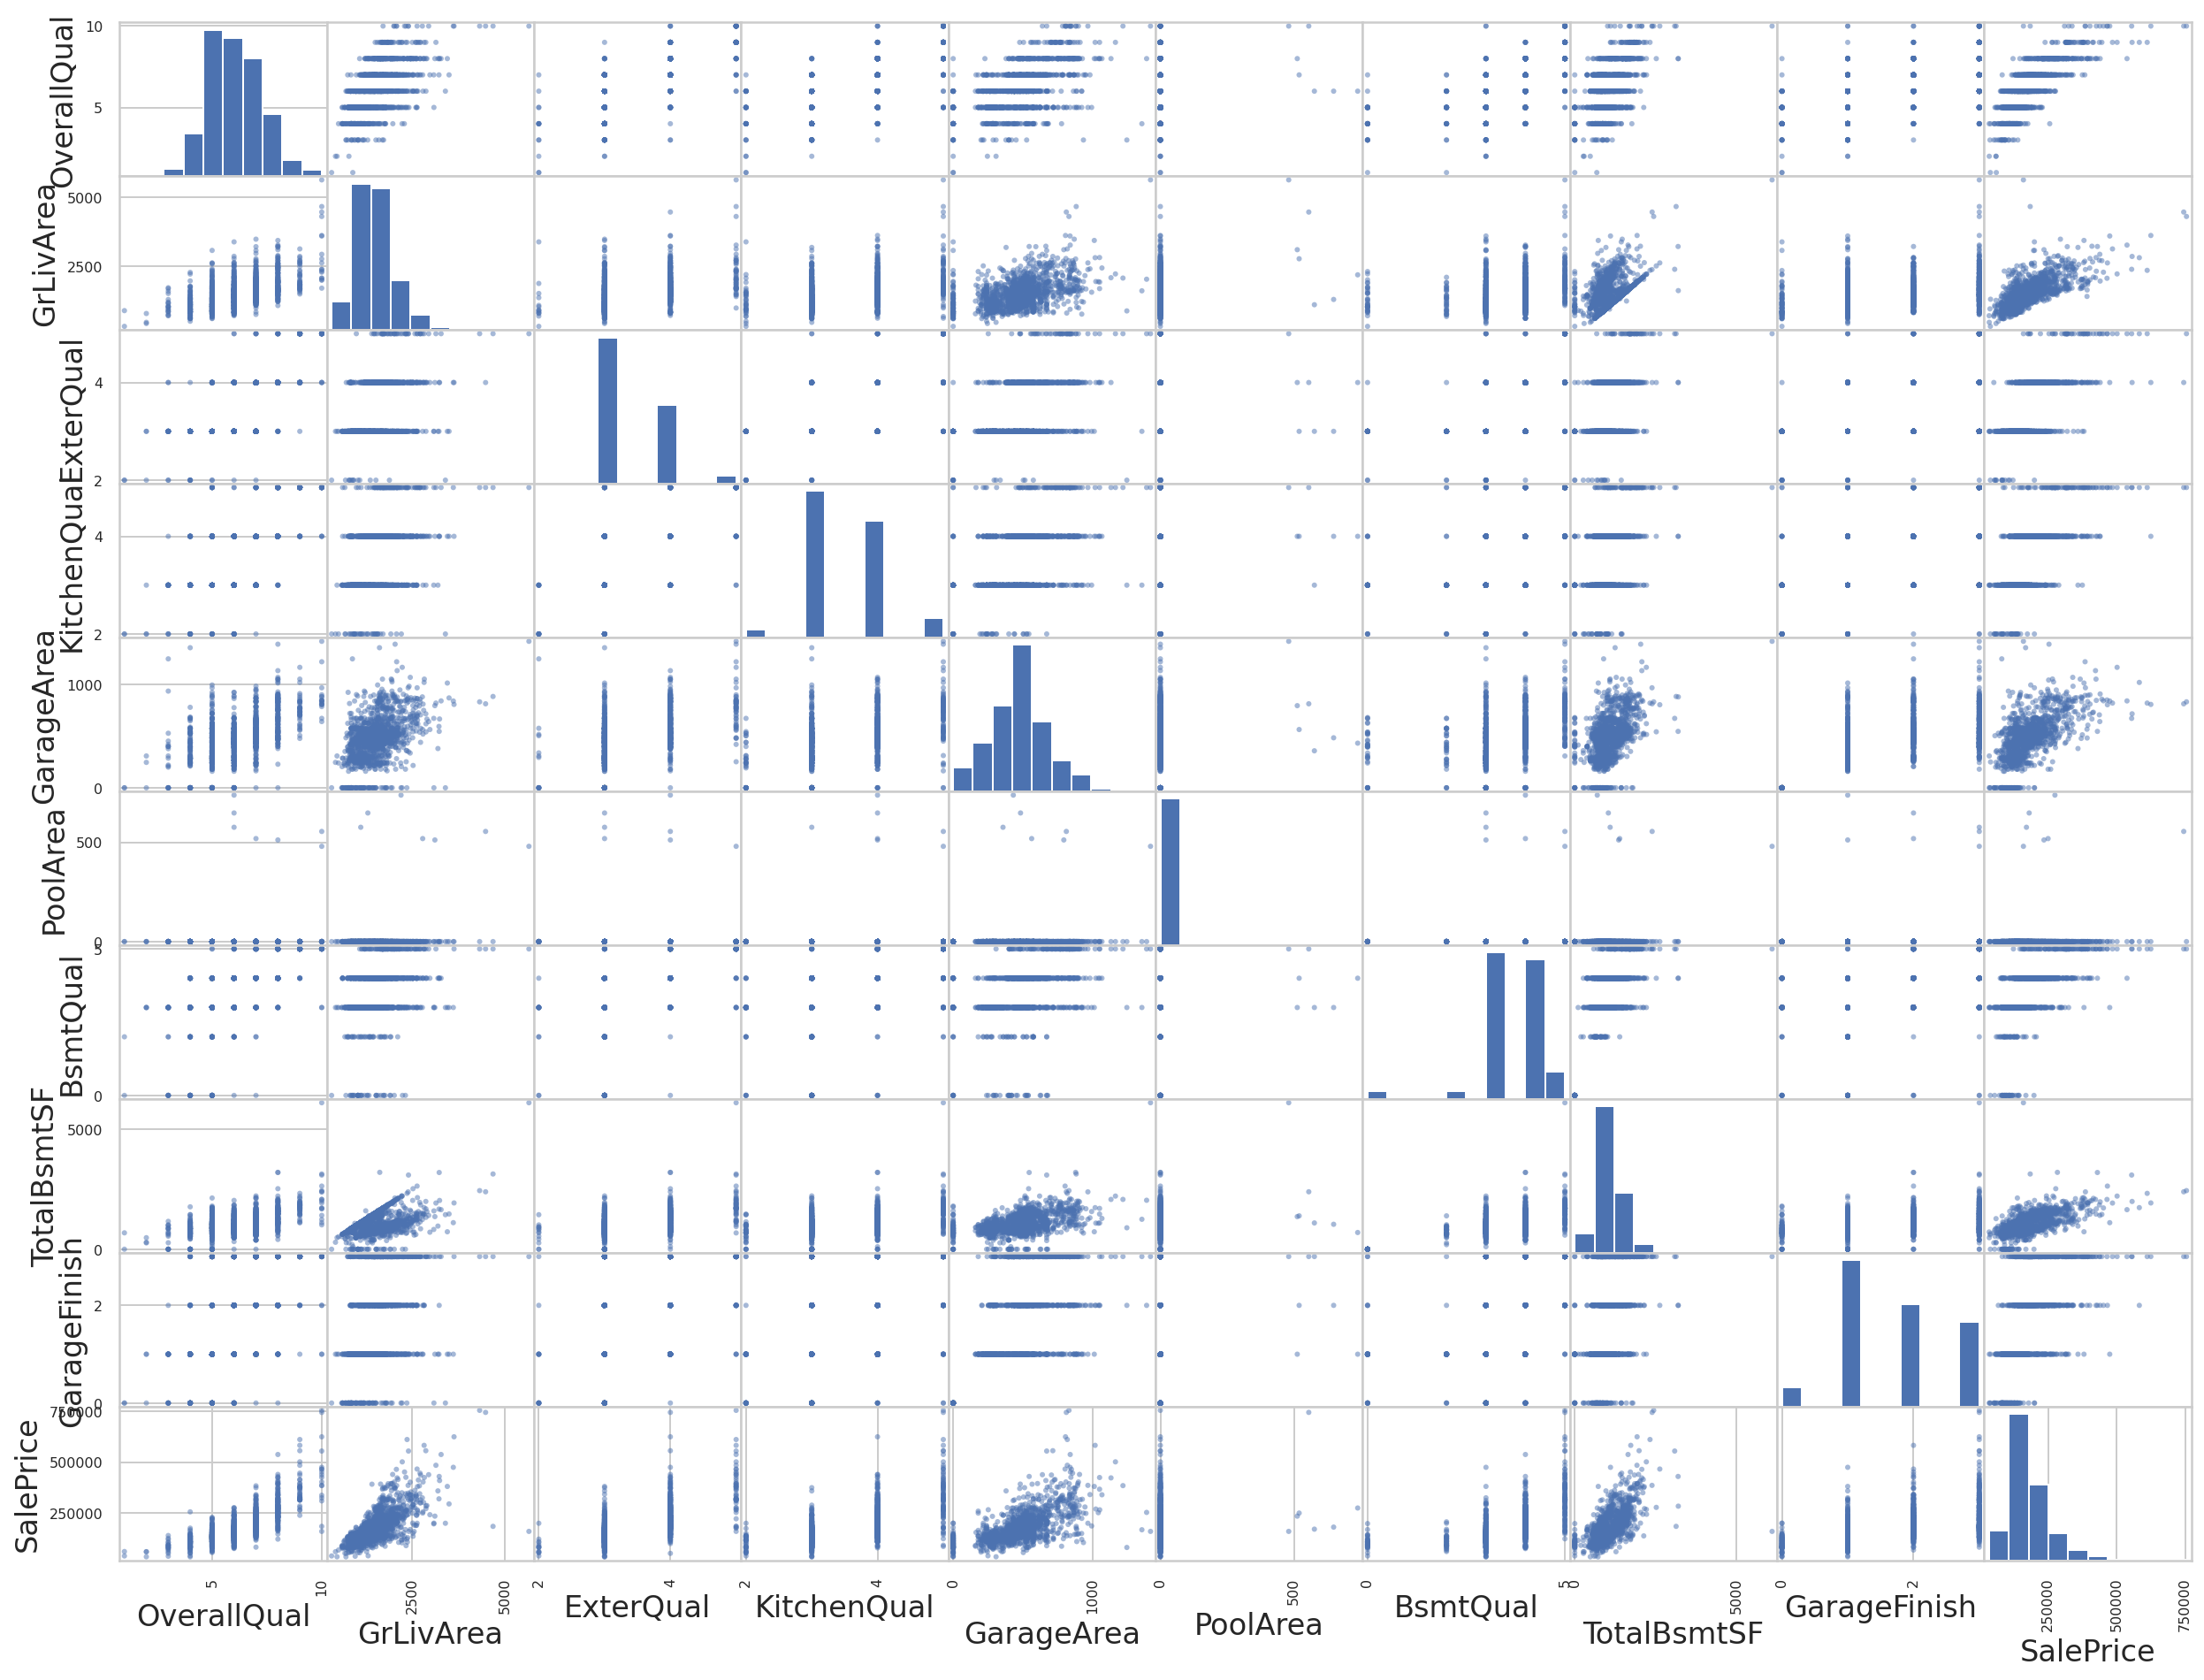

In [ ]:
pd.plotting.scatter_matrix(filtered_df, figsize=(21, 16));

### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [ ]:
formula = "SalePrice ~ " + " + ".join(useful_columns[:-1])
print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + PoolArea + BsmtQual + TotalBsmtSF + GarageFinish


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``. 

__Замечание__ Кажется, линейным моделям приятнее когда данные нормальзованы, поэтому при построении моделей буду пользоваться `normalized_df`. Это, к тому же, помогает избавиться от ворнинга про мультиколлинеарность и большие значение, да и так проще, как мне кажется, воспринимать значение коэффициентов модели.

In [ ]:
normalized_df = (filtered_df - filtered_df.mean()) / filtered_df.std()

In [ ]:
simple_model = smf.ols(formula, data=normalized_df)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     581.5
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:57:03   Log-Likelihood:                -955.68
No. Observations:                1460   AIC:                             1931.
Df Residuals:                    1450   BIC:                             1984.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.353e-16      0.012   1.11e-14   

После работы кода должна, выше должна получится примерно такая картинка:

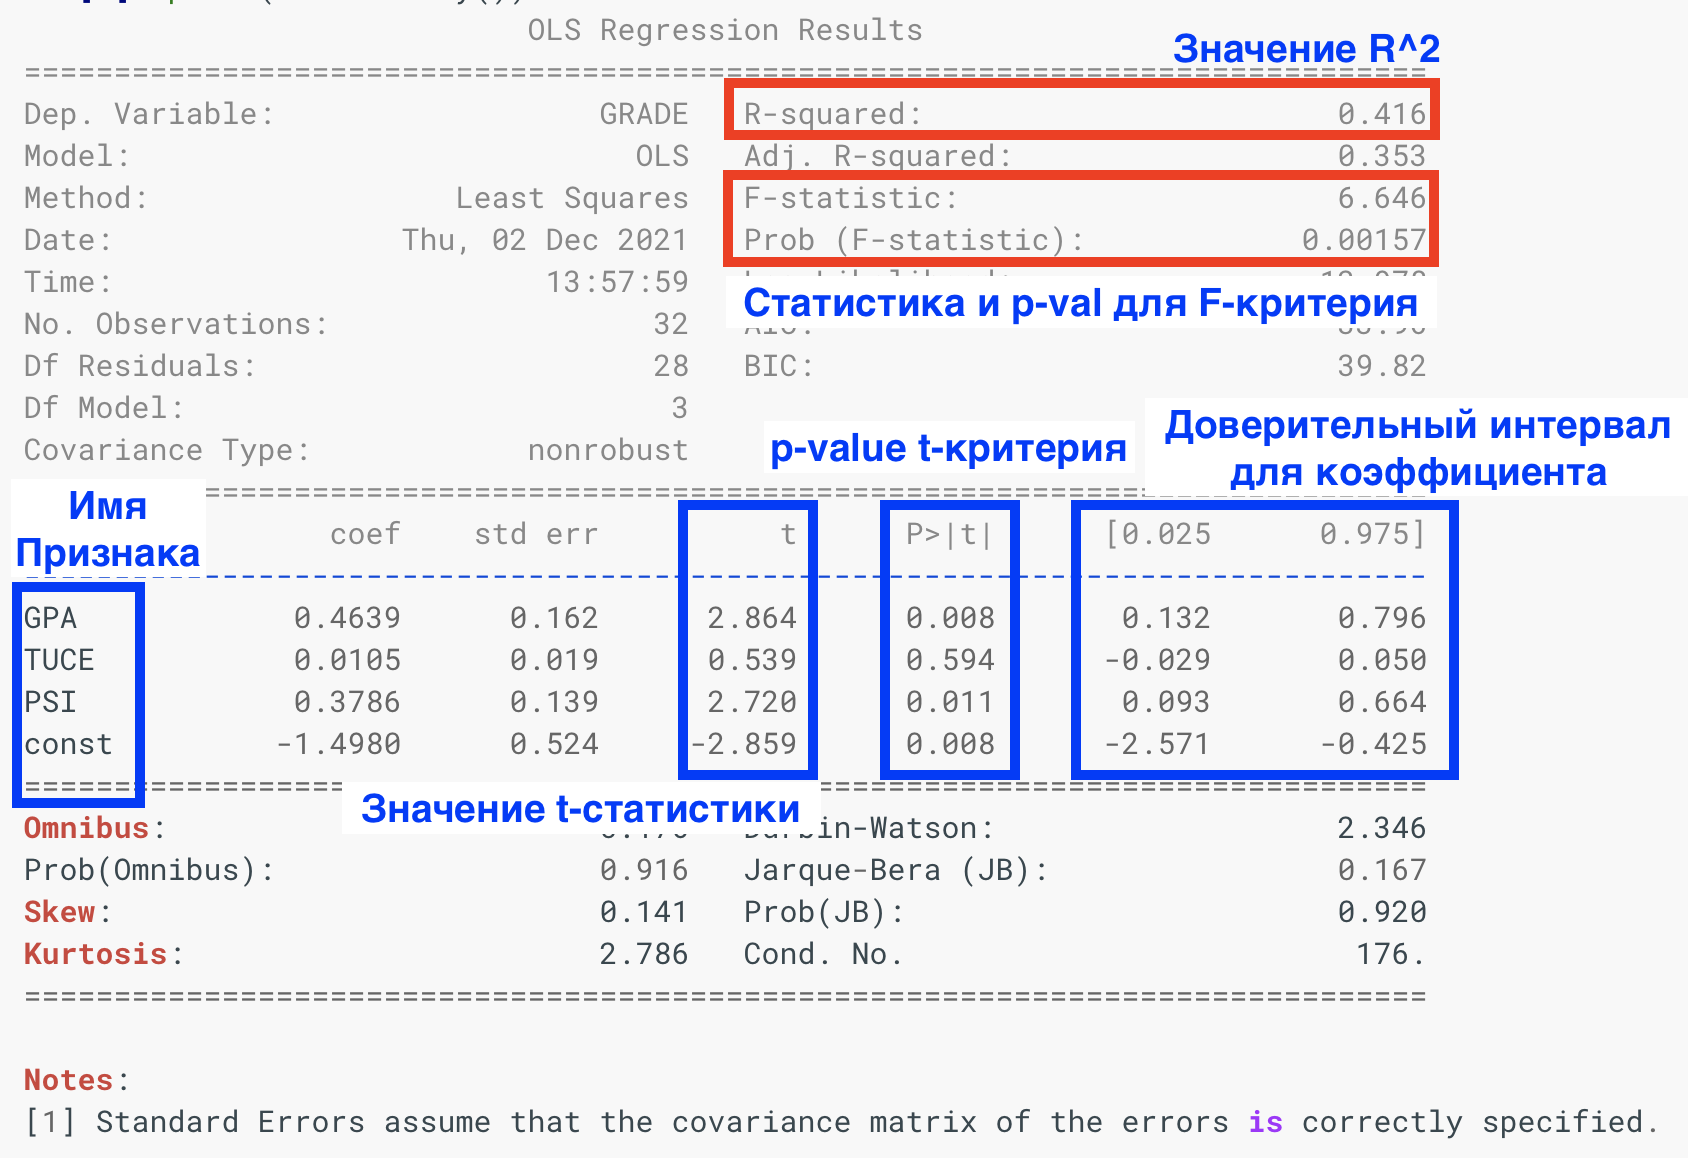


В примере название фичей намеренно изменены.

Можно заметить, что сверху располагается уже известный вам $R^2$. Далее чуть ниже располагются статистика и p-value (уровень достигаемой значимости) для F-критерия. Проверяется гипотеза о том, что наша модель работает лучше константы.

В мини-таблице есть проверка каждого признака на его значимость в модели с помощью t-критерия. Проверяется гипотеза о том, что модель без этого признака описывает не хуже, чем модель с этим признаком. Если значение p-value низкое, то, вероятно, признак статистически важен для модели. Таким образом можно осуществлять отбор признаков.




### Гетероскедастичность ошибки

Оценка, полученная с помощью гауссовской линейной модели будет справдлива лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_model.resid``, а параметры из ``fitted_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [ ]:
p_val_het = sms.diagnostic.het_breuschpagan(
    resid=fitted_simple_model.resid,
    exog_het=fitted_simple_model.model.exog
)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 5.431361130997812e-95


Отвергается ли гипотеза о гомоскедастичности остатков? Что это озночает?

**Ответ:** p-value очень маленький, поэтому базовая гипотеза о том что выполнены условия гомоскедастичности остатков отвергается.

В случаях, когда распределения остатков не является гомоскедастичном оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

In [ ]:
white_model = smf.ols(formula, data=normalized_df)

fitted_white_model = white_model.fit(cov_type="HC1")

print(fitted_white_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     266.7
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          5.44e-300
Time:                        16:57:03   Log-Likelihood:                -955.68
No. Observations:                1460   AIC:                             1931.
Df Residuals:                    1450   BIC:                             1984.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.353e-16      0.012   1.11e-14   

Проанализируйте результаты. Как изменились p-value для t-критериев? Как изменился коэффициент $R^2$?

**Ответ:** p-value для t критериев неплохо подрос для некторых параметров таких как `PoolArea`, `TotalBsmtSF`, `BsmtQual`. Значение критерия $R^2$ не изменилось.

Теперь мы действительно можем оценивать то, насколько важен тот или иной признак. Давайте отфильтруем наш датасет и оставим в нем только значимые признаки на уровне значимости $\alpha = 0.05$. (используйте t-критерий).



In [ ]:
features_to_filter = ['PoolArea']

filtered_columns = useful_columns

for f_t_f in features_to_filter:
    idx_to_filter = useful_columns.index(f_t_f)
    filtered_columns.pop(idx_to_filter)

In [ ]:
df['PoolArea'].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

Какие признаки оказались не значимы и почему?

**Ответ:** `PoolArea` оказался не значимым. Видимо, потому что в большинстве домов продаваемых домов просто нет бассейнов (как мы видим в ячейке выше). Плюс думаю зависит во многом от специфики данных, которые анализируются. То есть в каких-то крутых агенствах по недвижимости, где много богатых покупателей, этот фактор возможно играет неплохую роль, а в наших данных, это видимо не так.

Теперь снова обучим новую модель только на значимых признаках и получим summary. Не забудьте про поправку Уайта!

In [ ]:
filtered_formula =  "SalePrice ~ " + " + ".join(filtered_columns[:-1])
filtered_formula

'SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + BsmtQual + TotalBsmtSF + GarageFinish'

In [ ]:
filtered_model = smf.ols(filtered_formula, data=normalized_df)

fitted_filtered_model = filtered_model.fit(cov_type="HC1")

print(fitted_filtered_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     300.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          4.12e-301
Time:                        18:56:36   Log-Likelihood:                -956.44
No. Observations:                1460   AIC:                             1931.
Df Residuals:                    1451   BIC:                             1978.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.353e-16      0.012   1.11e-14   

Как изменился коэффициент $R^2$? Всегда ли бОльший $R^2$ говорит о правильной модели? Расскажите о своих рассуждениях!

**Ответ:** $R^2$ снова не изменился 😔. Однако значение F-статистики и ее p-value уменьшилось. 

Никаких хороших идей не приходило, поэтому пошел за ответами в интернет:

> Основная проблема использования $R^2$ для оценки качества модели заключается в том, что его значение увеличивается (не уменьшается) от добавления в модель новых переменных, даже если эти переменные никакого отношения к объясняемой переменной не имеют! Поэтому сравнение моделей с разным количеством факторов с помощью коэффициента детерминации, вообще говоря, некорректно. Для этих целей можно использовать альтернативные показатели.

### Преобразование целевого признака

Обратим свое внимание на целевую переменную. Ниде постройте гистограммы для признака ``SalePrice``. А так же для логарифма от ``SalePrice``. Сделайте это на разных картинках. Можно использовать subplot.

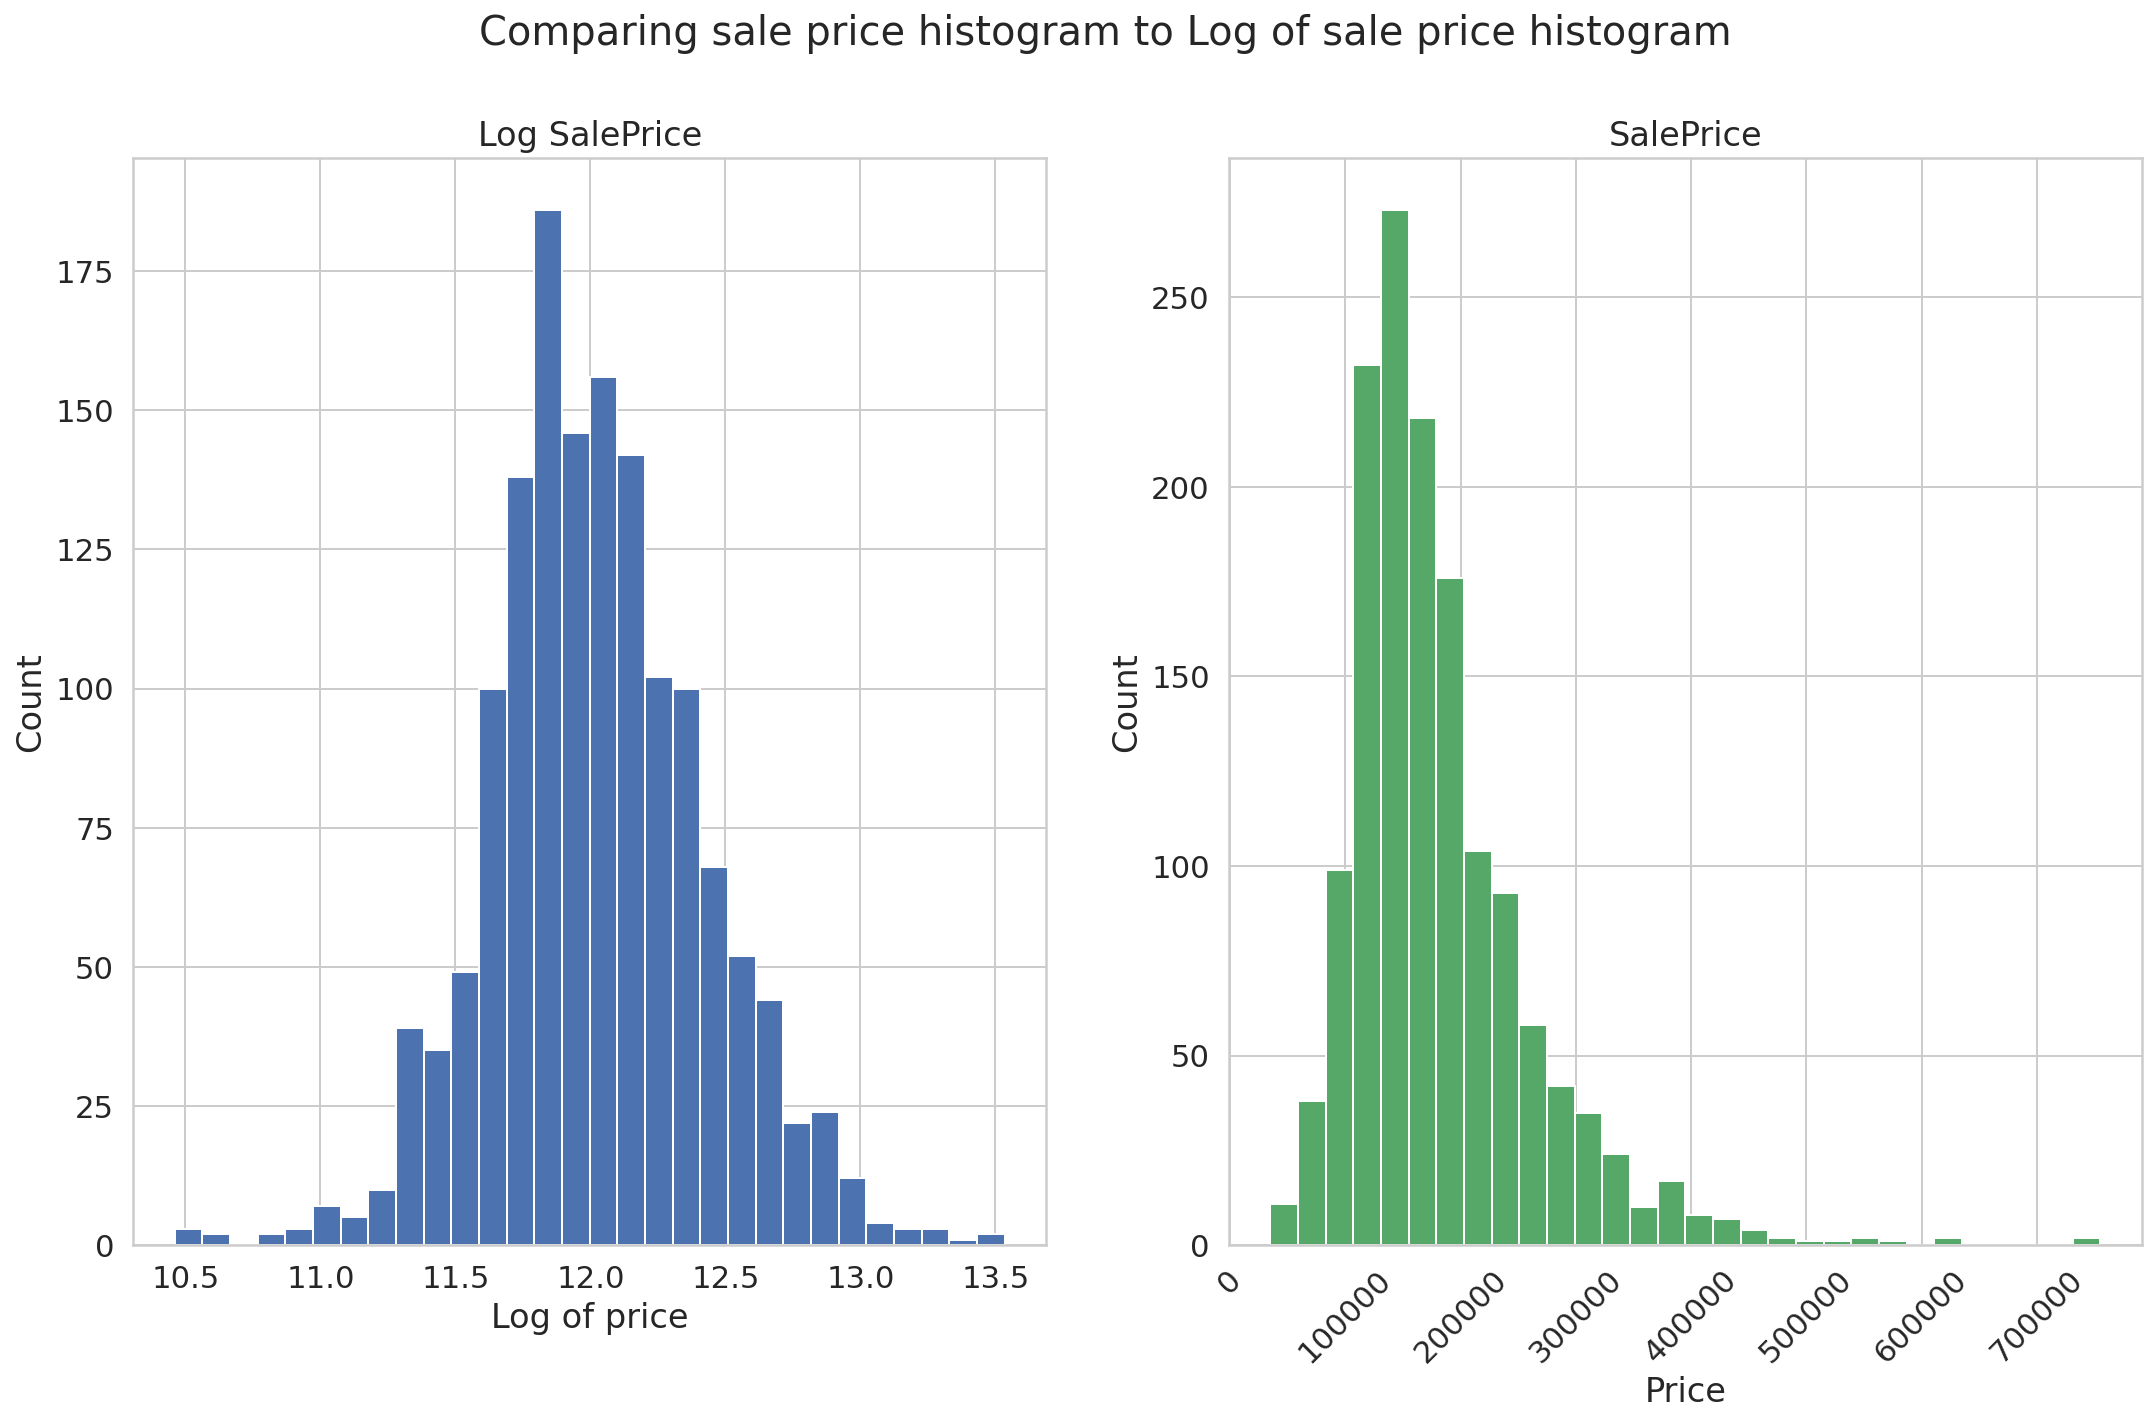

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
fig.suptitle('Comparing sale price histogram to Log of sale price histogram', fontsize=20)
ax1.hist(np.log(filtered_df['SalePrice']), bins=30)
ax2.hist(filtered_df['SalePrice'], bins=30, color='g')
plt.xticks(rotation=45)


ax1.set(title='Log SalePrice', xlabel='Log of price', ylabel='Count')
ax2.set(title='SalePrice', xlabel='Price', ylabel='Count')


fig.show()

Какой из графиков выглядит более "Гауссовским"?

**Ответ:** Как видно логарифм от цены является более "гауссовским", так как больше похож на плотность нормального распределения.

Теперь давайте снова посмотрим на распределение остатков от линейной модели. Начертим qqplot для нормального распределения и гистограмму остатков.

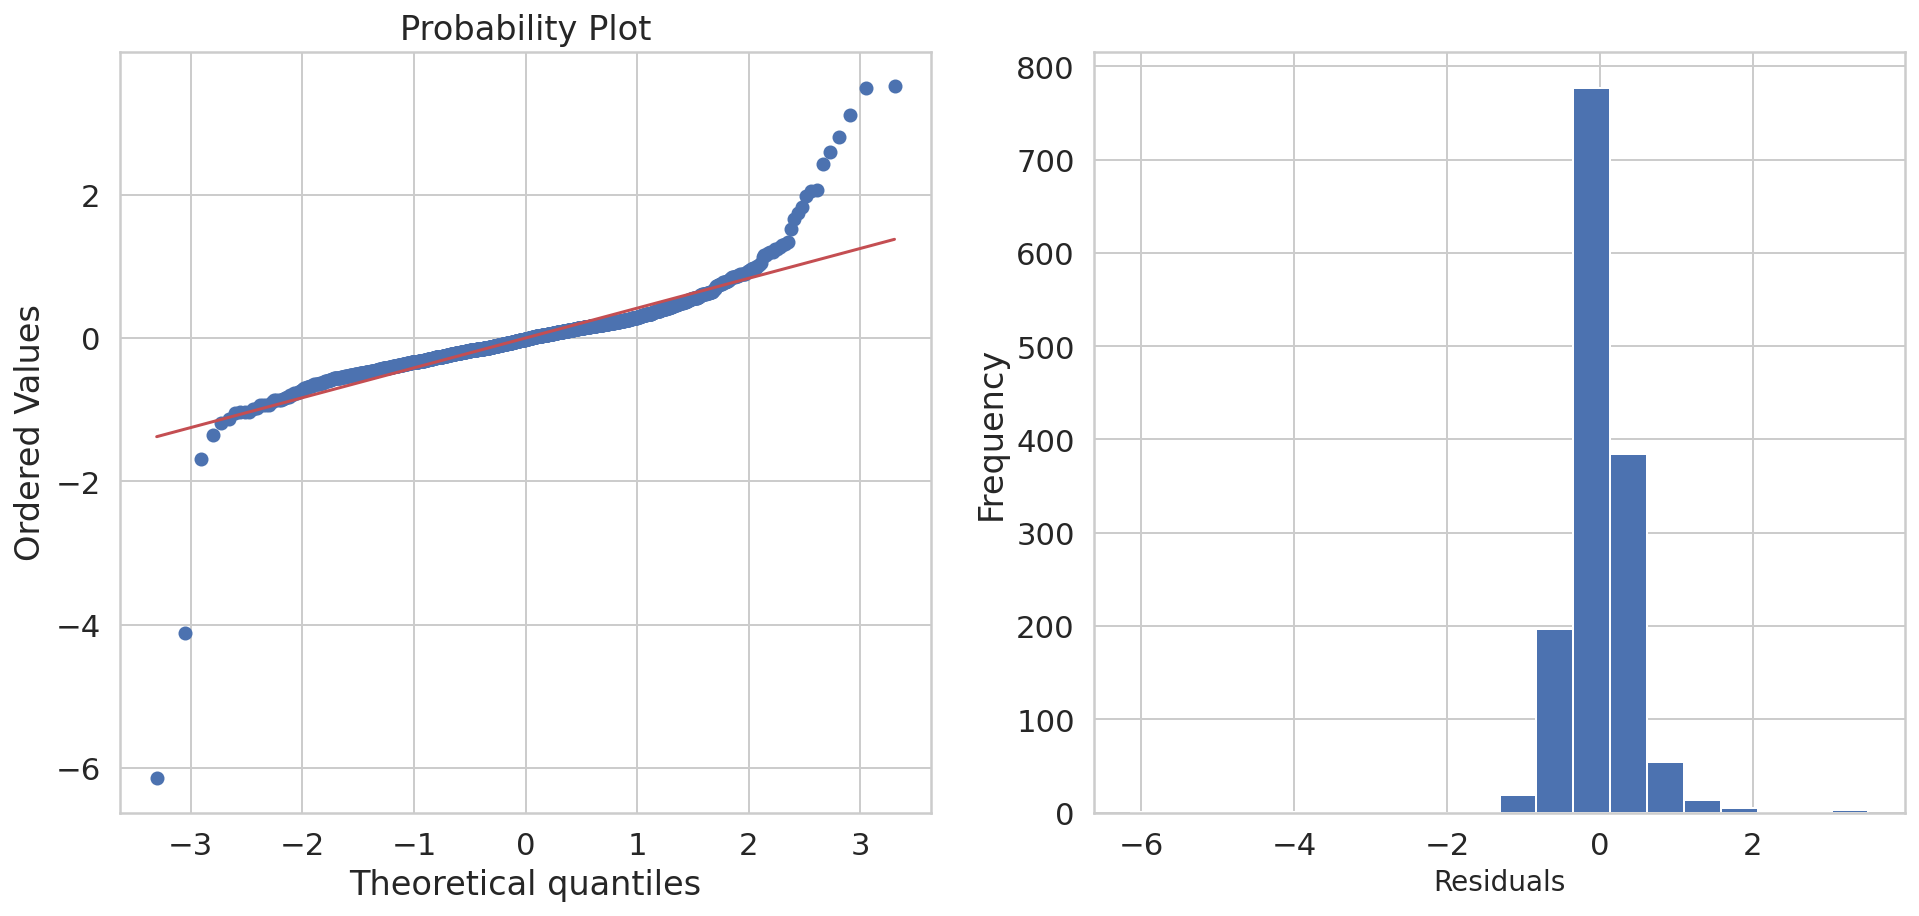

In [ ]:
import scipy

plt.figure(figsize=(16,7))
plt.subplot(121)
scipy.stats.probplot(fitted_filtered_model.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted_filtered_model.resid.plot.hist(bins=20)
plt.xlabel('Residuals', fontsize=14)
plt.show()

Как вы считаете, можно ли сказать, что распределение остатков это нормальное распределение?

**Ответ:** Думаю, что можно, потому что и гистограмма остатков похожа на плотность нормального, и по графику квантилей тоже видно большое совпадение с квантилями теоретического нормально распределения, хотя в хвостах конечно присутствует расхождение.

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

In [ ]:
log_formula = "np.log(SalePrice) ~ " + " + ".join(filtered_columns[:-1])
print(log_formula)

np.log(SalePrice) ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + BsmtQual + TotalBsmtSF + GarageFinish


In [ ]:
log_model = smf.ols(log_formula, data=filtered_df)

fitted_log_model = log_model.fit(cov_type="HC1")

print(fitted_log_model.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     599.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:44:01   Log-Likelihood:                 499.69
No. Observations:                1460   AIC:                            -981.4
Df Residuals:                    1451   BIC:                            -933.8
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.4070      0.035    298.718   

Как изменился коэффициент $R^2$? Модель лучше стала понимать данные?

**Ответ:** значение коэффициента $R^2$ увеличилось! Плюс мы видим, что теперь для признаков `ExterQual`, `TotalBsmtSF` p-value чтобы не отклонить гипотезу о том, что модель решает задачу без них не хуже.

Постройте графики, аналогичные тем, что встретились нам на две ячейки выше (qqplot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм. 

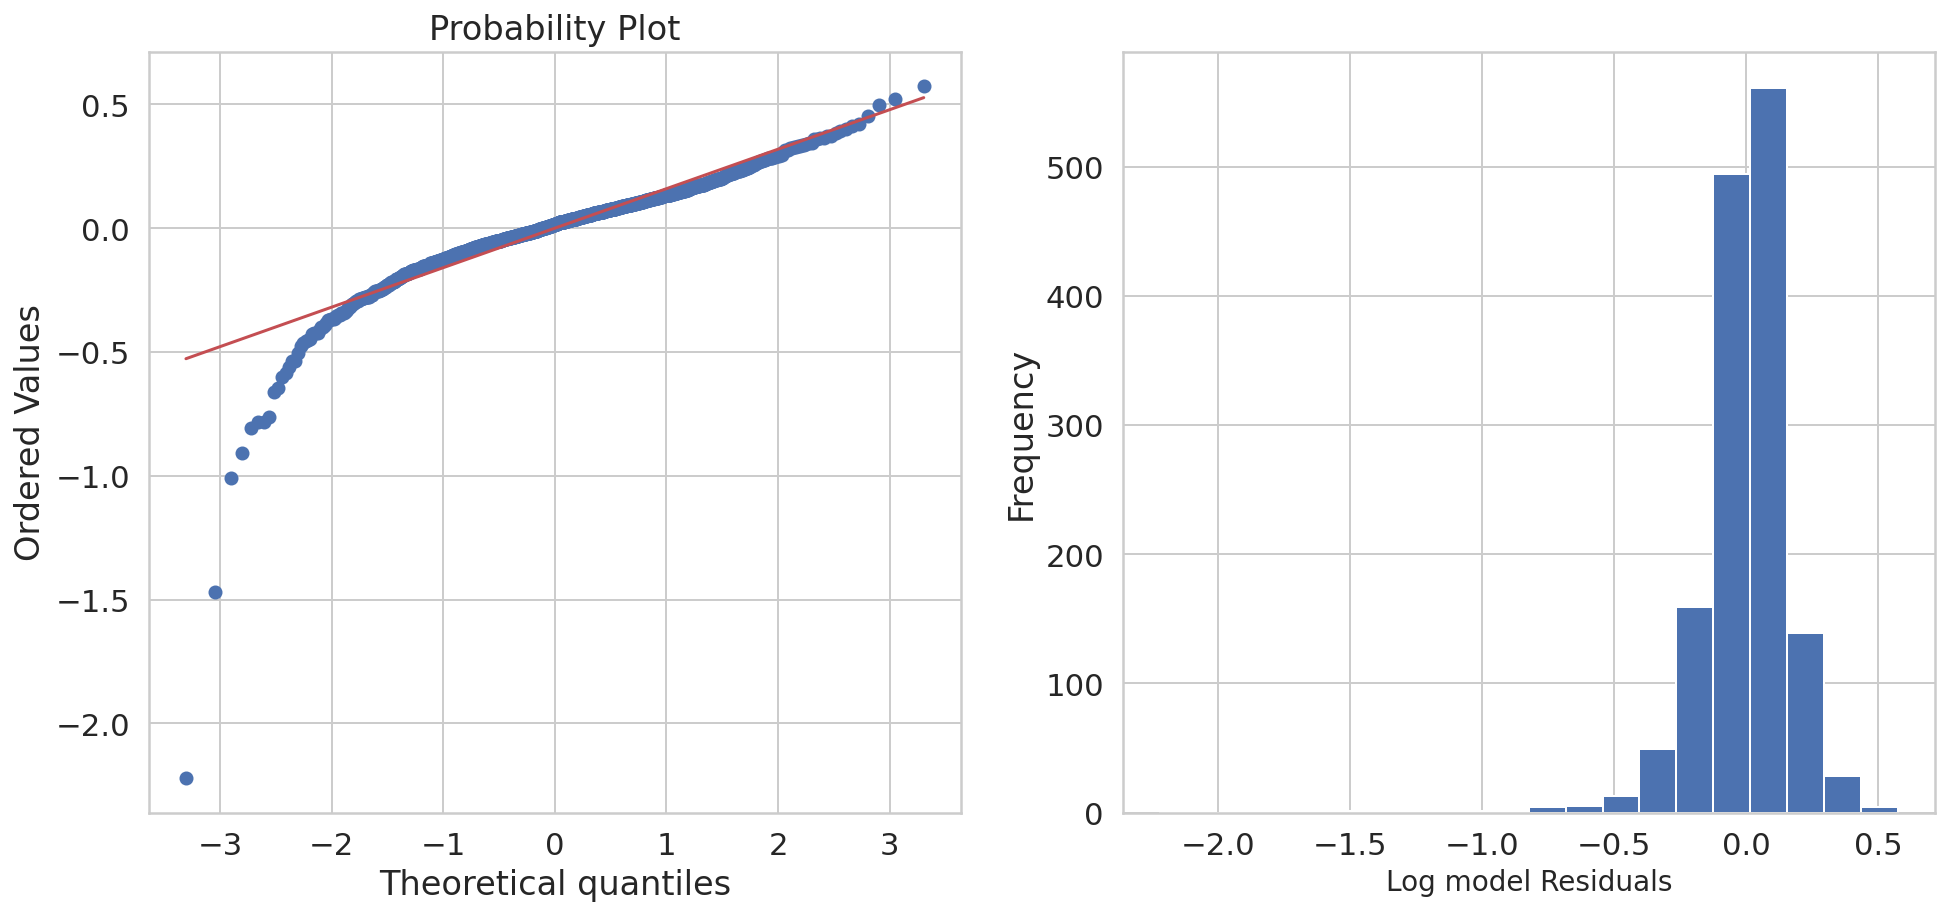

In [ ]:
plt.figure(figsize=(16,7))
plt.subplot(121)
scipy.stats.probplot(fitted_log_model.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted_log_model.resid.plot.hist(bins=20)
plt.xlabel('Log model Residuals', fontsize=14)
plt.show()

Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:**

Считаю, что такое может быть полезно почти всегда и речь не только про логарифм, а вообще про любое внесение нелинейности в формулу. Линейная модель часто очень далека от того, чтобы описать нашу зависимость наилучшим образом. Если бы все можно было решать только линейными моделями мир был бы другим...

Наверно, примерно так он (мир) мог бы выглядеть:
![](https://pbs.twimg.com/media/EX4eRsPXkAEgSzB.jpg:large).